In [1]:
import os
from pathlib import Path
import copy
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import pickle
import time
import datetime
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import tqdm.notebook as tq
import cv2 as cv

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Random
import random
from random import choice
from random import shuffle

#Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models 
from torch.utils.data import DataLoader,Dataset
from torch import optim
from PIL import Image

#Dim reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score

#Livelossplot
!pip install livelossplot --quiet
from livelossplot import PlotLosses

def path_to_label(path):
    path = path.split('\\')
    label = ''
    for el in path[4:-1]:
        label += el + '-'
    return label

In [2]:
#import of data sets (see report for more information)

# All brands but Givenchy
train_df = pd.read_csv('all_brands_but_givenchy.csv')
support_df = pd.read_csv('support_givenchy.csv')
query_df = pd.read_csv('query_givenchy.csv')
train_df.label = train_df.path.apply(lambda x:path_to_label(x))
support_df.label = support_df.path.apply(lambda x:path_to_label(x))
query_df.label = query_df.path.apply(lambda x:path_to_label(x))

# Validation test on 50 categories from Versace
support_versace = pd.read_csv('support_50_categories_local.csv')
query_versace = pd.read_csv('query_50_categories_local.csv')

mask = train_df['label'].isin(query_versace.label.to_numpy())
train_df = train_df[~mask]

In [3]:
def enforce_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    rgen = np.random.default_rng(seed)
    return rgen

rgen = enforce_all_seeds(42)

class TripletDataset(Dataset):
    ''' Implements dataset creation for siamese network. Keeps track of selected images'''

    def __init__(self,df_paths_labels,length,chosen_labels=None,transform=None):
        self.df = df_paths_labels
        self.len_df = len(df_paths_labels)    
        if chosen_labels is not None:
            self.chosen_labels = chosen_labels
        else:
            self.chosen_labels = df_paths_labels.labels.unique()
        # self.selected_images = []
        self.length = length
        self.transform = transform
        
    def __getitem__(self,index):
        path_anch = random.choice(self.df.loc[self.df.label.isin(self.chosen_labels)].path.values)
        # print(path_anch)
        label_anch = path_to_label(path_anch)
        # print(label_anch)
        # self.selected_images.append(path_anch)

        path_pos = random.choice(self.df.loc[(self.df.label == label_anch) & ~(self.df.path == path_anch)].path.values)
        # self.selected_images.append(path_pos)
        
        path_neg = random.choice(self.df.loc[(self.df.label != label_anch)].path.values)
        # self.selected_images.append(path_neg)

        img_anch = Image.open(path_anch).convert("RGB")
        img_pos = Image.open(path_pos).convert("RGB")
        img_neg = Image.open(path_neg).convert("RGB")

        if self.transform is not None:
            img_anch = self.transform(img_anch)
            img_pos = self.transform(img_pos)
            img_neg = self.transform(img_neg)
        
        return img_anch, img_pos, img_neg
    
    def __len__(self):
        return self.length
    
class ResNet50Triplet(nn.Module):

    def __init__(self):
        super(ResNet50Triplet, self).__init__()
        
        #importing ResNet50 and freezing all weights
        model = models.resnet18(pretrained=True)
        for param in model.parameters():
            param.requires_grad = True
        model.fc = nn.Sequential()
        self.conv = model
        
        #fc layers

        self.fc1 = nn.Sequential(nn.Linear(512,512),nn.LeakyReLU())
        self.fc2 = nn.Linear(512,256)
    
    def forward_one(self, x):
        x = self.conv(x)
        x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
        x = F.sigmoid(x)
#         x = F.normalize(x, dim=-1, p=2)

        return x

    def forward(self, anch, pos, neg):
        anch_output = self.forward_one(anch)
        pos_output = self.forward_one(pos)
        neg_output = self.forward_one(neg)
        return anch_output, pos_output, neg_output
    
def mean_average_precision(net, support_df, query_df):
    def preprocess(path):
        '''returns 224x224 image in tensor formed ready to be fed to Siamese network'''
        #Transformer
        transformer = transforms.Compose([transforms.Resize((224, 224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        return transformer(Image.open(path).convert("RGB"))

    def forward_pass(path, net):
        '''Performs a fordward pass into the net'''
        img = preprocess(path)
        # print(img.shape)
        y = net.forward_one(img.unsqueeze(0).cuda())
        y = y.detach().cpu().numpy()
        return y

    support_df['embedded_images'] = support_df.path.apply(lambda x:forward_pass(x, net))
    query_df['embedded_images'] = query_df.path.apply(lambda x:forward_pass(x, net))

    def calculate_AP(label):
        '''calculates AP for the given label'''
        # Ground truth vector
        y_ground = support_df.label.apply(lambda x: 1 if x==label else 0).values
        
        # Embedded query
        img_embedded = query_df.embedded_images.loc[query_df.label == label].values[0]
        
    #     print(img_em.sha)
        
        def distance_to_query(x):
            return -np.linalg.norm(x-img_embedded)
        
        # Distances vector
        y_distances = support_df.embedded_images.apply(lambda x: distance_to_query(x))
        return average_precision_score(y_ground, y_distances)

    query_df['AP'] = query_df.label.apply(lambda x:calculate_AP(x))
    mAP = np.mean(query_df['AP'].values)
    return mAP

## Entries

In [4]:
def train_resnet(epochs, margin, learning_rate, dataset_length, batch_size, p_hard_mining, opti, transfo, data_aug, saved_model=''):

    # Logs and liveplotloss initialization
    counter = []
    loss_history = []
    hard_examples_history = []
    mean_loss_history = []
    iteration_number = 0

    today = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    exp_name = 'ResNet50_'+str(epochs)+'epochs_'+str(margin)+'margin_' + \
        str(opti)+str(learning_rate)+str(100*p_hard_mining)+'mining_'+data_aug
    ROOT = r'C:\Users\vasch\OneDrive\Navee/'
    weights_file = exp_name + str(today) + '.pt'
    CSV_logs_file = exp_name + str(today) + '.csv'
    df_logs = pd.DataFrame(
        {'epoch': [], 'batch': [], 'loss': [], 'hard_loss': [], 'Givenchy mAP': [], 'Versace mAP':[]})
    plt.rcParams['figure.figsize'] = [15, 8]
    groups = {'triplet loss': [
        'mean loss', 'hard_examples loss', 'last batch loss'], 'Givenchy mAP': ['Givenchy mAP','Versace mAP']}
    liveloss = PlotLosses(groups=groups)

    # Dataset, dataloader
    transformer = transfo
    dataset = TripletDataset(train_df,
                             length=dataset_length,
                             chosen_labels=train_df.label.unique(),
                             transform=transformer)

    dataloader = DataLoader(dataset,
                            shuffle=False,
                            num_workers=0,
                            batch_size=batch_size)
    nb_batchs = dataset.length//batch_size

    # Hyperparameters
    EPOCHS = epochs
    top_k = int(batch_size*p_hard_mining)
    MARGIN = margin

    # Model, losses, optimizer
    if saved_model == '':
        net = ResNet50Triplet().cuda()
    else:
        net = torch.load(ROOT+'training_logs_Navee/'+saved_model)

    trip_loss = nn.TripletMarginLoss(margin=MARGIN, p=2.0)
    temp_loss = nn.TripletMarginLoss(margin=MARGIN, p=2.0, reduce=False)
    if opti == 'adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    else:
        return 'Undefined optimizer'

    start = time.time()
    for epoch in range(EPOCHS):
        mean_epoch_loss = []
        for i, batch in enumerate(dataloader):
            net.train()
            img0, img1, img2 = batch
            img0, img1, img2 = img0.cuda(), img1.cuda(), img2.cuda()
            optimizer.zero_grad()

            with torch.no_grad():
                temp_output_0, temp_output_1, temp_output_2 = net(
                    img0, img1, img2)
                temp_loss_batch = temp_loss(
                    temp_output_0, temp_output_1, temp_output_2)
                mean_epoch_loss.append(torch.mean(temp_loss_batch).item())
                loss, indexes = torch.sort(temp_loss_batch, dim=0)

            # Negative mining: retrieves indexes of the given % of worse examples
            indexes = indexes[-top_k:]

            # Computes forward pass on selected pairs.
            anch_output, pos_output, neg_output = net(img0[indexes].squeeze().cuda(
            ), img1[indexes].squeeze().cuda(), img2[indexes].squeeze().cuda())
            triplet_loss = trip_loss(anch_output, pos_output, neg_output)
            triplet_loss.backward()
            optimizer.step()

            print(
                f"\r Epoch number {epoch+1}/{EPOCHS}, batch number {i+1}/{int(dataset.length/batch_size)}, current hard loss={triplet_loss.item(): .5}, batch loss={mean_epoch_loss[-1]: .5}", end='')

            net.eval()

            # Logs update
            hard_examples_history.append(triplet_loss)
            loss_history.append(torch.mean(temp_loss_batch))
            if i + 1 != nb_batchs:
                df_logs = df_logs.append(pd.DataFrame({'epoch': [epoch+1], 'batch': [i+1], 'loss': [
                                         mean_epoch_loss[-1]], 'hard_loss': [triplet_loss.item()], 'Givenchy mAP': [np.nan], 'Versace mAP': [np.nan]}))
            else:
                giv_mAP = mean_average_precision(net, support_df, query_df)
                ver_mAP = mean_average_precision(net, support_versace, query_versace)
                df_logs = df_logs.append(pd.DataFrame({'epoch': [epoch+1], 'batch': [i+1], 'loss': [
                                         mean_epoch_loss[-1]], 'hard_loss': [triplet_loss.item()], 'Givenchy mAP': [giv_mAP], 'Versace mAP': [ver_mAP]}))

        mean_loss_history.append(np.mean(mean_epoch_loss))
        df_logs.to_csv(ROOT+'training_logs_Navee/'+CSV_logs_file, index=False)
        # Livelossplot logs
        liveloss.update({'mean loss': np.mean(mean_epoch_loss),
                         'hard_examples loss': triplet_loss.item(),
                         'last batch loss': mean_epoch_loss[-1],
                         'Givenchy mAP': giv_mAP,
                         'Versace mAP': ver_mAP})
        liveloss.send()
        if epoch % 5 == 0:
            torch.save(net, ROOT+'training_logs_Navee/'+weights_file)
    end = time.time()
    elapsed = end - start
    print(f'\n Training time {elapsed: .10}s, that is ' +
          str(timedelta(seconds=elapsed)))

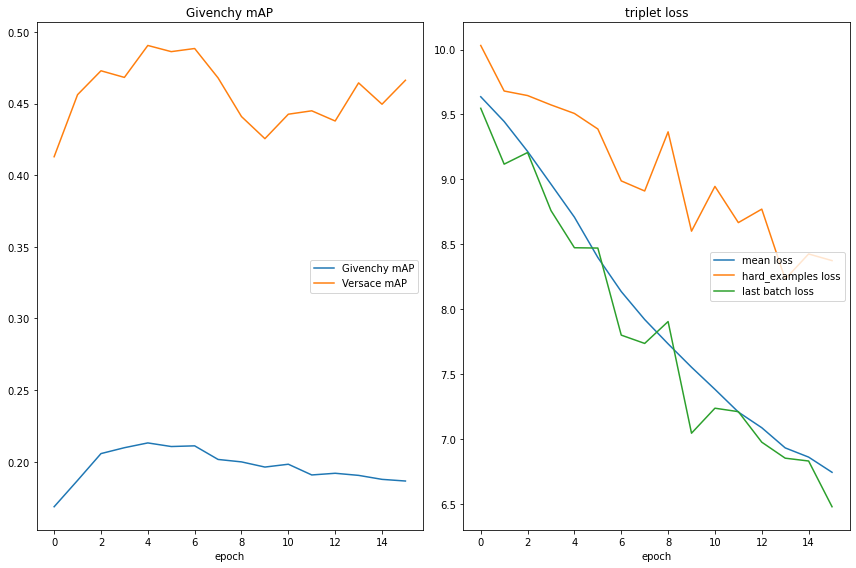

Givenchy mAP
	Givenchy mAP     	 (min:    0.169, max:    0.213, cur:    0.187)
	Versace mAP      	 (min:    0.413, max:    0.491, cur:    0.466)
triplet loss
	mean loss        	 (min:    6.745, max:    9.636, cur:    6.745)
	hard_examples loss 	 (min:    8.232, max:   10.031, cur:    8.375)
	last batch loss  	 (min:    6.480, max:    9.547, cur:    6.480)
 Epoch number 17/100, batch number 119/200, current hard loss= 9.2134, batch loss= 6.4996

KeyboardInterrupt: 

In [5]:
transformer = transforms.Compose([transforms.Resize((224, 224)),
                                  transforms.RandomHorizontalFlip(p=0.5),
#                                   transforms.RandomRotation(5),
#                                   transforms.RandomCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_resnet(epochs=100, margin=10.0, learning_rate=0.00001, dataset_length=5000, batch_size=25,
             p_hard_mining=0.35, opti='adam', transfo=transformer, data_aug='h_flip+all_data+alltrain', saved_model='')